In order to successfully complete this assignment you need to:
1. Participate both individually and in groups during class.
2. Submit this notebook to the `exercise` folder in your `cmse802-yourlastname` repository by 10pm __the SAME DAY of the class__. Late assignment will receive <=80% of the grade.

### <p style="text-align: left;"> &#9989; Put your name here: Pavan Yachamaneni </p>

---

# __Statistical Analysis: In-Class__

<img alt="Short video of a tool that demonstrates the natrual occurace of gaussian curves using a plico toy" src="https://i1.wp.com/psychbrief.com/wp-content/uploads/2017/12/normal-distribution-2.gif?resize=444%2C250&ssl=1">

Image From: https://en.wikipedia.org/wiki/Hydra

## Learning objectives

At the end of the exercise, you should be able to:
- Compare basic linear model performance against random guess.
- Use exploratory data analysis to figure out what kinds of issues are there in the data.
- Explain why feature engineering is important.
- Engineer features to get better models.
- Evaluate final model with testing data.


## Outline


1. [Review Pre-class assignment](#preclass)
1. [Basic linear model continued](#basic)
1. [Potential problem with features](#preprocess)
1. [Evaluate "final" model](#evaluate)

----
<a name="preclass"></a>

# 1. Pre-Class Assignment Review

In your group, discussion the following.

&#9989; <font color=red>**QUESTION:**</font> Did you get stuck doing pre-class exercise or find some ideas confusing? If so where did you get stuck? What did you find confusing? What solutions did your groupmates suggest?

<font size=+3>&#9998;</font> Replace with your answer to the above question!

----
<a name="basic"></a>
# 2. Basic linear model continued

## 2.1 Establish the basic linear model

We will rebuild the basic linear model using the California housing data. Note that, instead of just split data into training and testing, here we split data into:
- __training__ (60%)
- __validation__ (20%)
- __testing__ (20%). 

This is because, in a statistical modeling project, we need to explore ways to process raw feature values to see if a particular way leads to better model. For this to work, we:
1. Perform one modification to features, => need to explain why we changes that feature.
2. Build a model with the modified features with __training__ data.
3. Assess how well the model works with __validation__ data. If the modification improve the model further, we keep that modification.
4. Repeat step 1-3 with other modifications till the best performing model is identified based on certain modifications.
5. With the best performing model, we then __EVALUATE__ the model with __testing__ data that __have never been used to train anything__.

The steps 1~4 are collectively referred to as __feature engineering__ that involves __turn raw data into informative features for modeling purposes__. 

The __train/validation/test__ split is extremely important practice to prevent data leakage.


&#9989; **<font color=blue>DO THIS:</font>** In the preclass, we show you how a basic linear model can be trained and tested. in the cell below the different steps for building the model are compiled into couple helper function. 

Provide comments as indicated.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import seaborn as sns
import copy

def get_train_val_test(df, rand_state):
    '''Specify response and predictive variables and return train, validataion,
       and testing sets
    Args:
      df (DataFrame): the Calinfornia housing data with the 1st 8 columns as
         features and the last column as the response variable.
      rand_state (float): the random seed for splitting train/test data.
    Return:
      data_split (tuple): training, validation, and testing data splits
    '''
  
    X = df.iloc[:,:-1]      # Input data
    y = df["MedHouseVal"]   # taeget variable 

    ## Test Train split of data with test size is 20% of whole data
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=rand_state)

    ## Further splitting the X_train, Y_train to get X_val and Y_val with 25% size
    X_train, X_val, y_train, y_val = \
        train_test_split(X_train, y_train, test_size=0.25, random_state=1)

    # Note the order: train, val, test
    data_split = (X_train, X_val, X_test, y_train, y_val, y_test)

    return data_split

def train_validate(X_train, X_val, y_train, y_val, draw=1):
    """Train a linear model, make predicting on test set, and evaluate model
    Args:
      X_train, y_train, X_val, y_val (DataFrames): from get_train_val_test()
      draw (int): plot the scatterplot or not
    Return:
      lm (LinearRegression): trained model
      spearman (float): spearman's rank correlation
    """

    # creating an object of linear regression from sk learn
    lm = LinearRegression()   
    
    # COMMENT: what does this do?
    lm.fit(X_train, y_train)  

    # COMMENT: what does this do?
    y_preds = lm.predict(X_val) 

    if draw:
        plt.figure(figsize = (6,6))
        plt.scatter(y_val, y_preds, alpha=0.2)
        plt.xlabel("True MedHouseVal")
        plt.ylabel("Predicted MedHouseVal")
        plt.plot([0, 7], [0, 7], '--', lw=1, color="red")
        plt.grid(); plt.xlim(0,7); plt.ylim(0,7); plt.show()

    spearman = spearmanr(y_val, y_preds)[0]

    # Return the fitted model and correlation value
    return lm, spearman

&#9989; **<font color=blue>DO THIS:</font>** Run the following cell that will:

- Specify `rand_state` that is used as the random seed for splitting training and testing sets. This is used so you can reproducibly split dataset.
- Read the Calinfornia housing data as a dataframe.
- Train a basic linear model using the housing data with the helper functions above to get two objects:
  - The trained linear model as `lm_original`.
  - Spearman rank correlation value as `spearman_original` and print it out.

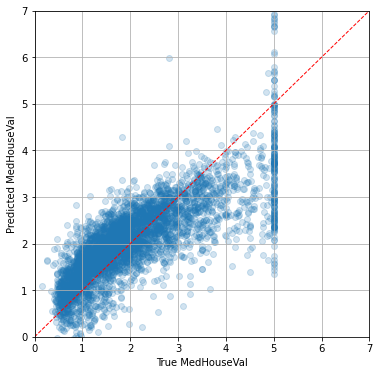

0.8104693515405089

In [2]:
# Random seed for consistent train-val-test split
rand_state = 42

# Read California housing data as a DataFrame
ca_house = fetch_california_housing(as_frame=True).frame

# Train-val-test splits
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_test(
                                                        ca_house, rand_state)

# Train and valide modei
lm_original, spearman_original = train_validate(X_train, X_val, y_train, y_val)
spearman_original

## 2.2 Performance of a naive model

A naive model here is defined as a model that make predictions based on __random guess__:
- One way we can build a naive model is by shuffling the response variable so is randomly ordered, diassociate its relationships with features.

&#9989; **<font color=blue>DO THIS:</font>** Pause a bit and think about the following: __What would you expect the Spearman's rank correlation will be and the scatter plot will look like if you use the shuffled y training data to train a model?__

In the following, code is included to generate `y_train_shuffled` which is used to build a basic linear model.

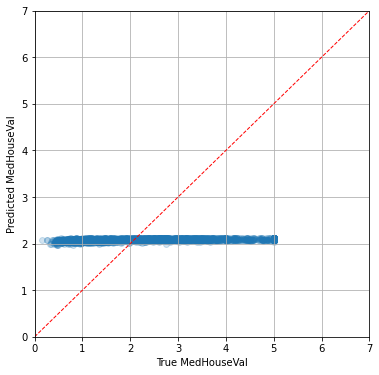

0.5047204967986618

In [25]:
# shuffled y_train
y_train_suffled = y_train.sample(frac=1, random_state=rand_state)
#x_train_suffled = x_train.sample(frac=1, random_state=rand_state)
lm_shuffled, spearman_shuffled = train_validate(X_train        , X_val,
                                                y_train_suffled, y_val)
spearman_shuffled

&#9989; **<font color=red>QUESTION:</font>** Looking at the Spearman's rank and the scatter plot:

- Are they as what you have expected? Why and why not? 
- Why do you think the predictions all centered at around 2?

<font size=+3>&#9998;</font> 
Shuffling created large bias in the data. And, this makes data centered around 2.

----
<a name="preprocess"></a>
# 3. Potential problem with features

If we look into the graphs generated in class. Hopefully you realize there are at least five potential problems:

1. __Outliers__
   - For example, the maximum value in `AveOccup` is 1243 (a housing complex? Concert hall? School?)
1. __Thresholding__
   - Apparently, someone decided that any houses above $5 million (not $5!) should be treated as $5 million.
1. __Parametric assumption__
   - Linear models generally assume that the relationships between features and response variable to be __linear__.
1. __Data range__
   - Different features have very difference ranges which may impact model performance.
1. __Colinearity__
   - This is defined as a situation where features are correlated with each other.

These potential problems can be resolved through feature engineering.


## 3.1 Deal with outliers by dropping extreme value rows

&#9989; **<font color=blue>DO THIS:</font>** Outliers are extreme values that may represent some issues with data. For example, the mean average occupancy for a house (`AveOccup`) is only 3 but the maximum value is 1243! Similarly, the average of `AveRooms` is 5.4 but the maximum value is 141.9. See for yourself by running the following code block.

In [12]:
ca_house[['AveOccup', 'AveRooms']].describe()

AveOccup      AveRooms
count  20640.000000  20640.000000
mean       3.070655      5.429000
std       10.386050      2.474173
min        0.692308      0.846154
25%        2.429741      4.440716
50%        2.818116      5.229129
75%        3.282261      6.052381
max     1243.333333    141.909091

&#9989; **<font color=blue>DO THIS:</font>** For each feature, let's only include instances (rows) with feature values that are:
- $> 0.1$ percentile
- $< 99.9$ percentile

Then use the filtered data to rebuild a model.

Comment on the lines as indicated.

In [17]:
# Get precentile value ranges for features
perc_range = pd.DataFrame([ca_house.quantile(q=0.001, axis=0), # 0.1 precentile 
                           ca_house.quantile(q=0.999, axis=0)])# 99.9 percentile
perc_range.head()

MedInc  HouseAge   AveRooms  AveBedrms  Population   AveOccup  \
0.001   0.5360       2.0   1.749902   0.675187      17.639   1.298738   
0.999  15.0001      52.0  34.199698   6.617232   10372.681  13.630443   

       Latitude  Longitude  MedHouseVal  
0.001  32.57000 -124.18000     0.330917  
0.999  41.75361 -114.64639     5.000010

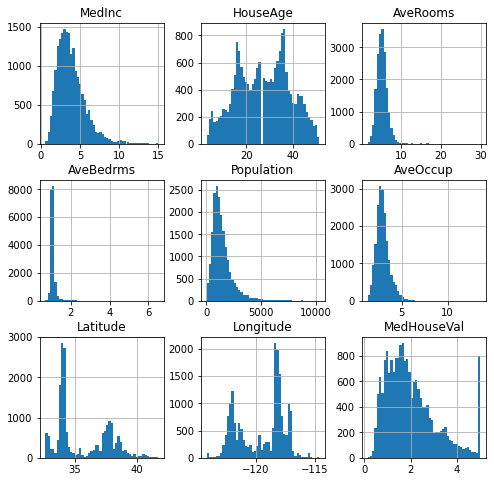

In [18]:
# Get 0.1 and 99.9 percentile values for all features

# copying into a temporary variable
ca_house_noout = copy.deepcopy(ca_house)

def filter_outliers(df, perc_range):
    '''Filter outliers in a dataframe using passed percentile ranges'''

    # From each colomn take only the values of 0.1 to 99.9 percentile
    for feat in df.columns[:-1]: # go through each feature
        # 0.1 percentile
        df = df[df[feat] > perc_range[feat].iloc[0,]]
        
        # 99.9 percentile
        df = df[df[feat] < perc_range[feat].iloc[1,]]

    return df

ca_house_noout = filter_outliers(ca_house_noout, perc_range)
                        
hist_ca_house_noout = ca_house_noout.hist(figsize=(8,8), bins=50)

&#9989; **<font color=blue>DO THIS:</font>** Run the following to call the helper functions to use `ca_house_noout` to build a model and report Spearman's rank. No need to draw scatter plot.

Does the model perform better?

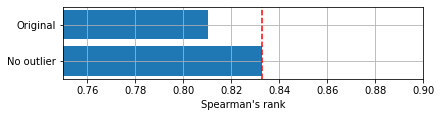

In [28]:
X_train_noout, X_val_noout, X_test_noout, y_train_noout, y_val_noout, y_test_noout = \
                            get_train_val_test(ca_house_noout, rand_state)

lm_noout, spearman_noout = train_validate(
                        X_train_noout, X_val_noout, y_train_noout, y_val_noout,
                        draw=0)

# Create horizontal bar plot of spearman rank values
spearman_values = [spearman_noout, spearman_original]
spearman_names  = ["No outlier", "Original"]

def horizontal_barplot(spearman_values, spearman_names):
    N = len(spearman_values)
    fig = plt.figure(figsize=(5,N*0.5))
    ax = fig.add_axes([0,0,1,1])
    ax.barh(np.arange(N), spearman_values)
    ax.set_yticks(np.arange(N))
    ax.set_yticklabels(spearman_names)
    ax.set_xlabel("Spearman's rank")
    ax.axvline(x=spearman_values[0], color="red", linestyle="--")
    ax.set_xlim(0.75,0.9); plt.grid(); plt.show()

horizontal_barplot(spearman_values, spearman_names)

__Thought__: The model with extreme value removed is better than the original model.

## 3.2 Deal with non-linearity via data transformation

We also suspect that `AveRooms`, `AveBedrms`, `Population`, and `AveOccup` are too skewed. 

&#9989; **<font color=blue>DO THIS:</font>** Let's log transformed features in `ca_house_noout` from __section 4.1__ and called the new DataFrame `ca_house_log`.

In the cell below, provide __detailed comment__ on how that lambda function works.

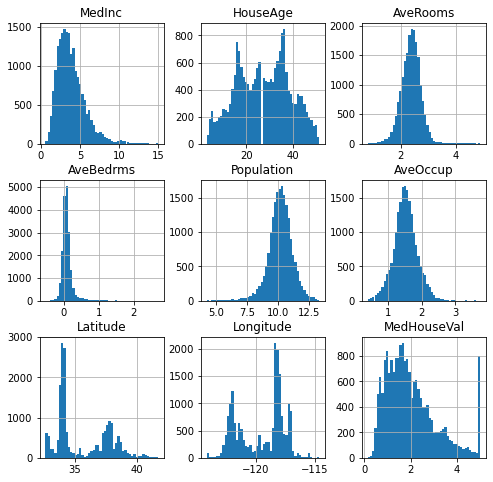

In [29]:
col_to_log = ["AveRooms", "AveBedrms", "Population", "AveOccup"]

## DETAILED COMMENT ON THIS LINE
ca_house_log = ca_house_noout.apply(
                lambda x: np.log2(x) if x.name in col_to_log else x)

hist_log = ca_house_log.hist(figsize=(8,8), bins=50)

&#9989; **<font color=blue>DO THIS:</font>** Ok, they looked better (not so skewed). Will the model perform better? To answer this question, write codes that will:

- Train a basic linear model with `ca_house_log`, the DataFrame that has no-ourlier __AND__ is log transformed .
- Assign the returned values to `lm_log` and `spearman_log`.
- Use the `horizontal_barplot` function defined earlier to compare `spearman_log`, `spearman_noout`, and `spearman_original`.

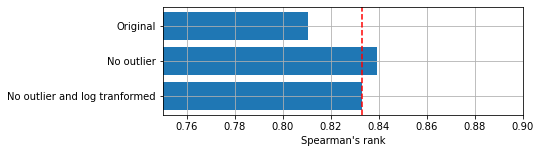

In [30]:
# put your code here
X_train_log, X_val_log, X_test_log, y_train_log, y_val_log, y_test_log = \
                            get_train_val_test(ca_house_log, rand_state)

lm_log, spearman_log = train_validate(
                        X_train_log, X_val_log, y_train_log, y_val_log,
                        draw=0)

# Create horizontal bar plot of spearman rank values
spearman_values = [spearman_noout, spearman_log, spearman_original]
spearman_names  = ["No outlier and log tranformed","No outlier", "Original"]

def horizontal_barplot(spearman_values, spearman_names):
    N = len(spearman_values)
    fig = plt.figure(figsize=(5,N*0.5))
    ax = fig.add_axes([0,0,1,1])
    ax.barh(np.arange(N), spearman_values)
    ax.set_yticks(np.arange(N))
    ax.set_yticklabels(spearman_names)
    ax.set_xlabel("Spearman's rank")
    ax.axvline(x=spearman_values[0], color="red", linestyle="--")
    ax.set_xlim(0.75,0.9); plt.grid(); plt.show()

horizontal_barplot(spearman_values, spearman_names)

__Thoughts__: Yes, this is even better than before (0.840).

## 3.3 Deal with colinearity by dropping features

&#9989; **<font color=blue>DO THIS:</font>** Latitude is highly, negatively correlated with Longitude (think California as a State with a left slant). Let's see if dropping `Latitude` will make the model better.

Comment on each of the following lines:

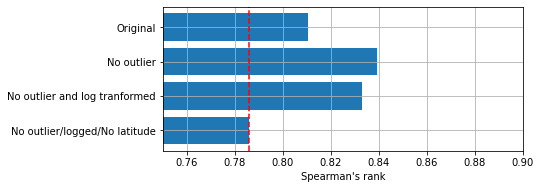

In [31]:
# COMMENT
ca_house_nolat = ca_house_log.drop(["Latitude"], axis=1)

# COMMENT
X_train_nolat, X_val_nolat, _, y_train_nolat, y_val_nolat, _ = \
                                get_train_val_test(ca_house_nolat, rand_state)

lm_nolat, spearman_nolat = train_validate(
                X_train_nolat, X_val_nolat, y_train_nolat, y_val_nolat, draw=0)

# Barplot
spearman_values = [spearman_nolat] + spearman_values
spearman_names  = ["No outlier/logged/No latitude"] + spearman_names

horizontal_barplot(spearman_values, spearman_names)


&#9989; **<font color=blue>DO THIS:</font>** Oops, it is worse. So not a good idea to drop it. So the best dataset is still the extreme value-free, log transformed data `ca_house_logged`. Take a look at the scatter plot below colored based on `MedHouseVal`:

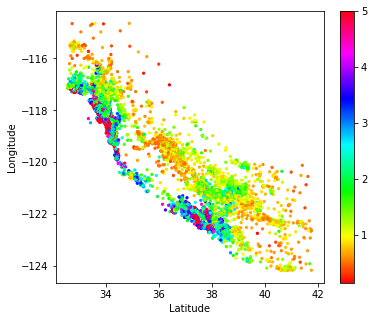

In [32]:
plt.figure(figsize=(6,5))
plt.scatter(ca_house_log["Latitude"], ca_house_log["Longitude"], 
            c=ca_house_log["MedHouseVal"], cmap="hsv", s=5)
plt.xlabel("Latitude"); plt.ylabel("Longitude"); plt.colorbar(); plt.show()

&#9989; **<font color=red>QUESTION:</font>** Discuss with your neighbor, can you explain why dropping Latitude is not a good idea, despite its strong collinearity with Longitude?

<font size=+3>&#9998;</font> we are loosing information.

## 3.4 Deal with data range via scaling

&#9989; **<font color=blue>DO THIS:</font>** Let see if there is any impact by scaling the features using `RobustScaler` which scale features depend on their percentile values, which not only scale data to similar ranges but also mitigate against the impact of outliers.

Comment on the indicated lines.

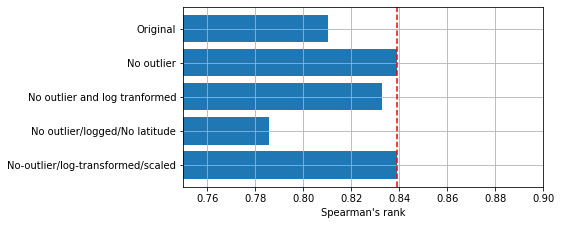

In [33]:
## COMMENT
scaler   = RobustScaler().fit(X_train_log)

## COMMENT
X_train_scale = scaler.transform(X_train_log)

## COMMENT
X_val_scale = scaler.transform(X_val_log)
# Y values are not scaled, so the same as before
y_train_scale = y_train_log
y_val_scale   = y_val_log
# Train model and measure performance
lm_scale, spearman_scale = train_validate(X_train_scale, X_val_scale, 
                                          y_train_scale, y_val_scale, draw=0)
# Plot
spearman_values = [spearman_scale] + spearman_values
spearman_names  = ["No-outlier/log-transformed/scaled"] + spearman_names
 
horizontal_barplot(spearman_values, spearman_names)

----
<a name="evaluate"></a>
# 4. Evaluate our "final" model with testing data

Let's say we are done exploring ways to get better features. Now it is time to evaluate just how good our model is using testing data that has been set aside all this time without being used in any training steps. 

&#9989; **<font color=blue>DO THIS:</font>** Write code that will evaluate the model performance using testing data (`X_test` and `y_test`) and print out the Spearman's rank. Note that:

- The best model is `lm_scale`.
- The best model use `X_train` and `X_val` values that: (1) do not have outliers, (2) are log-transformed, and (3) are scaled with RobustScaler. So you need to apply the same three processing steps to `X_test`.
- You cannot directly use `train_validate` but there are few lines in there that are helpful, particularly:
  - The line using the `predict` function of the trained model.
  - The line generating Spearman's rank correlation.

In [34]:
# put your codes here
y_test_scale  = y_test_log
X_test_scale = scaler.transform(X_test_log)
y_preds_scale = lm_scale.predict(X_test_scale)
spearman = spearmanr(y_test_scale, y_preds_scale)[0]

print(spearman)

0.8464760039870755


&#9989; **<font color=red>QUESTION:</font>** Is the testing result better or worse than the validation result? Is this what you expect? Why and why not?

<font size=+3>&#9998;</font> 
Yes, it is higher as expected because all the issues with data are removed.

-----
### Congratulations, we're done!